In [1]:
from glob import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import rioxarray
import pandas as pd
import matplotlib
import contextily as cx
from pyproj import CRS
import geopandas as gpd
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry.point import Point
import string
import matplotlib.dates as md

In [2]:
from matplotlib import rcParams
font_size = 17
rcParams['axes.titlesize'] = font_size
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.labelsize'] = font_size - 2
rcParams['xtick.labelsize'] = font_size - 2
rcParams['ytick.labelsize'] = font_size - 2
rcParams['legend.fontsize'] = font_size - 2
rcParams['figure.titlesize'] = font_size
rcParams['figure.titleweight'] = 'bold'

In [3]:
filename_1 = glob('../data/control_release/ENMAP01-____L3B*20221116*_plume0.nc')[0]
da_1 = xr.open_dataset(filename_1, decode_coords='all')['ch4']
df_1 = pd.read_csv(filename_1.replace('.nc', '.csv'))

filename_2 = glob('../data/control_release/PRS_L3*20211021*_plume0.nc')[0]
da_2 = xr.open_dataset(filename_2, decode_coords='all')['ch4']
df_2 = pd.read_csv(filename_2.replace('.nc', '.csv'))

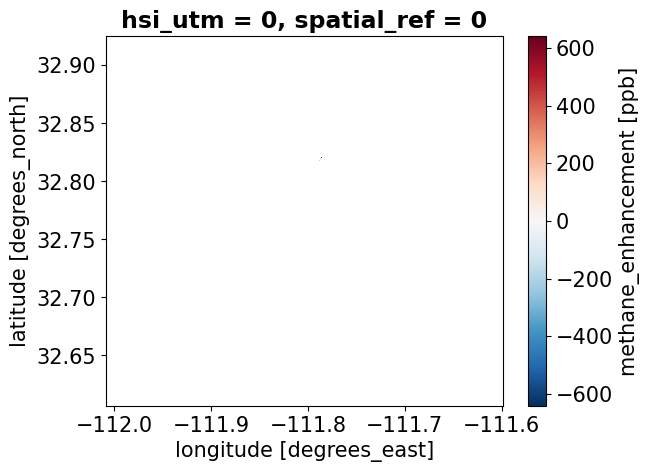

In [4]:
da_1.plot(x='longitude', y='latitude')

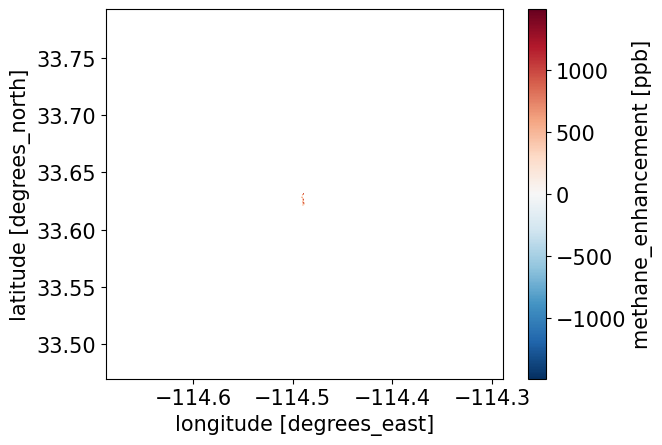

In [5]:
da_2.plot(x='longitude', y='latitude')

In [6]:
da_1.attrs['start_time'][:10], da_2.attrs['start_time'][:10]

('2022-11-16', '2021-10-21')

## Wind data

In [7]:
da_1.attrs

{'aot': 0.366,
 'description': 'methane enhancement derived by the 2110~2450 nm window (orthorectified by the rpc method)',
 'earthSunDist': 0.989081156,
 'end_time': '2022-11-16 18:40:50',
 'granule_id': 'ENMAP01-____L1B-DT0000005368_20221116T184050Z_005_V010302_20230704T084230Z',
 'long_name': 'methane_enhancement',
 'modifiers': array([], dtype=float64),
 'platform_name': 'ENMAP',
 'reader': 'hsi_l1b',
 'saa': 170.664804,
 'sensor': 'hsi',
 'standard_name': 'methane_enhancement',
 'start_time': '2022-11-16 18:40:50',
 'sza': 52.173398,
 'time': '2022-11-16 18:40:50.816563',
 'units': 'ppb',
 'vaa': 12.6639268964,
 'vza': 13.6552662518}

In [8]:
df_2021 = pd.read_csv('../data/control_release/2021.csv')
df_2022 = pd.read_csv('../data/control_release/2022.csv')
df_wind = pd.concat([df_2021, df_2022])
df_wind['datetime'] = pd.to_datetime(df_wind['datetime'])
df_wind.set_index(["datetime"], inplace=True)
df_wind = df_wind.sort_values(by=['datetime'])

In [9]:
def plot_wspd(df, data, ax):
    toverpass = data.attrs['start_time']

    ax.axvline(pd.Timestamp(toverpass), c='r', label='Overpass time')

    df_wind['wind_speed'].plot(ax=ax, style='.', label='Observation')
    plt.legend()


    ax.set_xlim([(pd.to_datetime(toverpass) - pd.Timedelta(10, unit='m')).round("5min"),
                (pd.to_datetime(toverpass) + pd.Timedelta(10, unit='m')).round("5min"),
                ],
                )
    ax.set_ylim(1, 10)

    ax.set_ylabel('Wind speed (m/s)')
    ax.set_xlabel('Time (UTC)')
    ax.xaxis.set_major_formatter(md.DateFormatter('%H:%M'))

    ax.set_title(f"{data.attrs['platform_name']} ({toverpass[:10]})")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


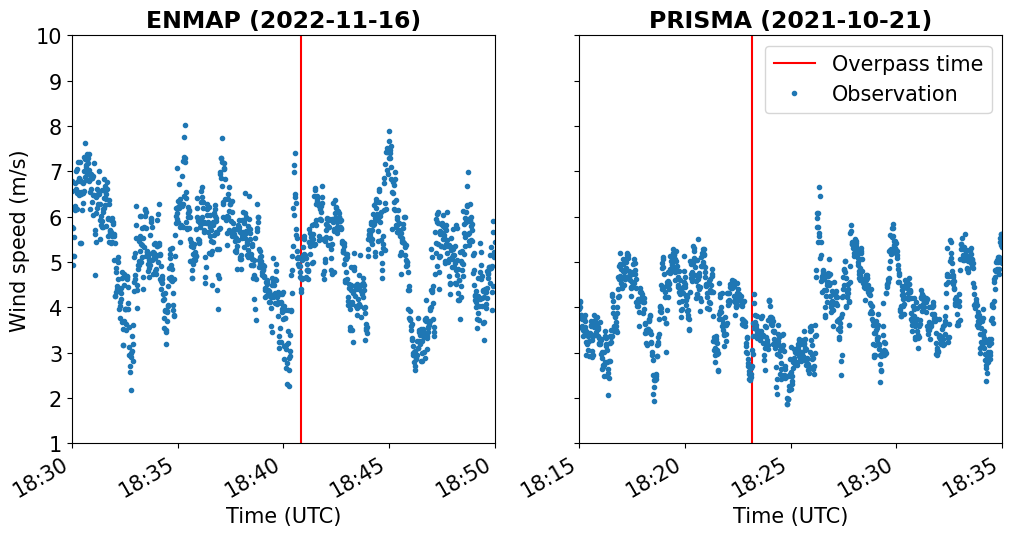

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)

plot_wspd(df_wind, da_1, axs[0])
plot_wspd(df_wind, da_2, axs[1])

## Emission

/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_67066/2963268193.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


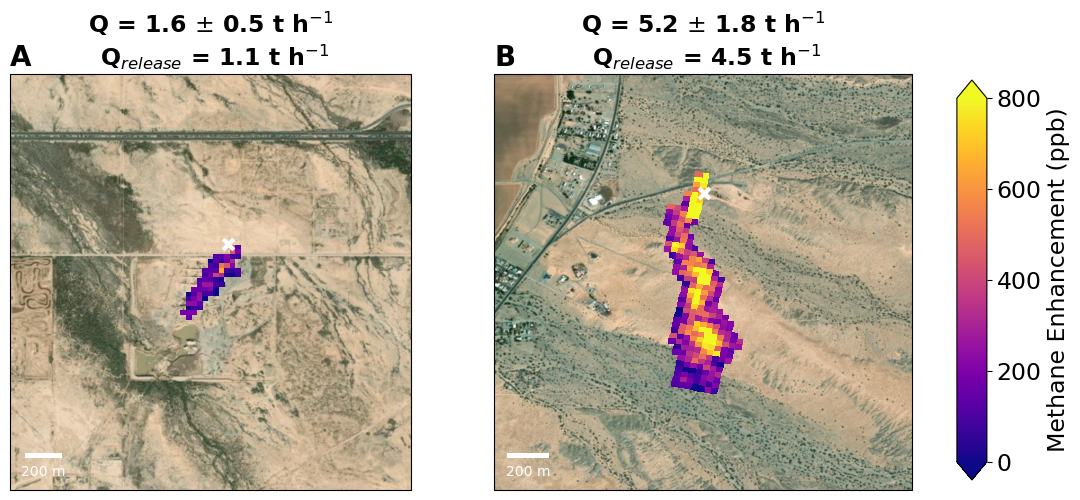

In [11]:
utm_zone = CRS.from_epsg(da_1.rio.crs.to_epsg()).to_dict()['zone']
crs = ccrs.UTM(zone=utm_zone, southern_hemisphere=True)

fig, axs = plt.subplots(figsize=(10, 5), ncols=2,
                      #  facecolor = plt.cm.Blues(.3),
                       subplot_kw={'projection':ccrs.PlateCarree()},
                     #   constrained_layout=True,
                       )

ax = axs[0]
m = da_1.plot(x='longitude', y='latitude',
            ax=ax, vmin=0, vmax=800, cmap='plasma',
            add_colorbar=False, rasterized=True
           )

lon_min = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].min() - 0.01
lon_max = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].max() + 0.01
lat_min = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].min() - 0.01
lat_max = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].max() + 0.01

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
cx.add_basemap(ax, crs=ccrs.PlateCarree(), source=cx.providers.Esri.WorldImagery)
# remove watermark
ax.texts[0].remove()

points = gpd.GeoSeries(
    [Point(lon_min, lat_min), Point(lon_min-1, lat_min)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(crs)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

scalebar = ScaleBar(distance_meters, location='lower left', pad=0.05, border_pad=0.5, frameon=False, color='white')
ax.add_artist(scalebar)

emission_str = f"{(df_1['emission']/1e3).round(1).item()} $\pm$ {(df_1['emission_uncertainty']/1e3).round(1).item()} t h$^{{-1}}$"
# ax.set_title(da_1.attrs['start_time'][:10] + '\n' + 'Q: '+ emission_str + ' Q$_{{release}}$: 1.1 t h$^{{-1}}$')
ax.set_title('Q = '+ emission_str + '\n Q$_{{release}}$ = 1.1 t h$^{{-1}}$')

ax = axs[1]
m = da_2.plot(x='longitude', y='latitude',
            ax=ax, vmin=0, vmax=800, cmap='plasma',
            add_colorbar=False, rasterized=True
           )

lon_min = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].min() - 0.007
lon_max = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].max() + 0.007
lat_min = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].min() - 0.005
lat_max = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].max() + 0.005

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
cx.add_basemap(ax, crs=ccrs.PlateCarree(), source=cx.providers.Esri.WorldImagery)
# remove watermark
ax.texts[0].remove()

# add colorbar
cax = fig.add_axes([1, 0.05, 0.03, 0.8])
cb = fig.colorbar(m, cax=cax, extend='both', orientation="vertical")
cb.ax.tick_params(labelsize=17)
cb.ax.set_ylabel('Methane Enhancement (ppb)', fontsize=17)

points = gpd.GeoSeries(
    [Point(lon_min, lat_min), Point(lon_min-1, lat_min)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(crs)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

scalebar = ScaleBar(distance_meters, location='lower left', pad=0.05, border_pad=0.5, frameon=False, color='white')
ax.add_artist(scalebar)

emission_str = f"{(df_2['emission']/1e3).round(1).item()} $\pm$ {(df_2['emission_uncertainty']/1e3).round(1).item()} t h$^{{-1}}$"
ax.set_title('Q = '+ emission_str + '\n Q$_{{release}}$ = 4.5 t h$^{{-1}}$')

fig.tight_layout()

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.02, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')


axs[0].scatter(-111.7857730, 32.8218205, marker='x', c='w', s=60, linewidth=3)
axs[1].scatter(-114.489150, 33.630645, marker='x', c='w', s=60, linewidth=3)

# fig.savefig('../figures/control_release.pdf', bbox_inches='tight')

/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_67066/304290506.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


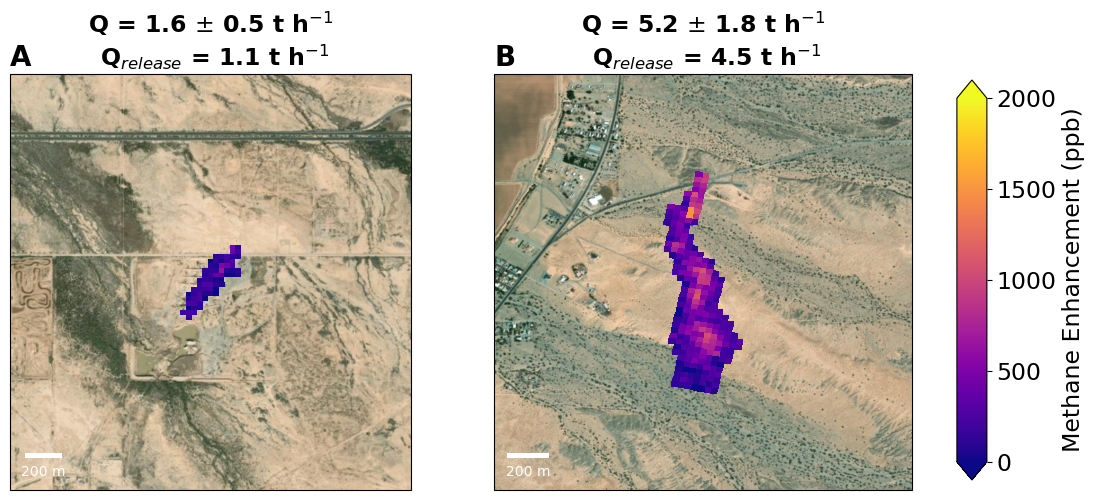

In [12]:
utm_zone = CRS.from_epsg(da_1.rio.crs.to_epsg()).to_dict()['zone']
crs = ccrs.UTM(zone=utm_zone, southern_hemisphere=True)

fig, axs = plt.subplots(figsize=(10, 5), ncols=2,
                      #  facecolor = plt.cm.Blues(.3),
                       subplot_kw={'projection':ccrs.PlateCarree()},
                     #   constrained_layout=True,
                       )

ax = axs[0]
m = da_1.plot(x='longitude', y='latitude',
            ax=ax, vmin=0, vmax=2*1e3, cmap='plasma',
            add_colorbar=False, rasterized=True
           )

lon_min = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].min() - 0.01
lon_max = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].max() + 0.01
lat_min = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].min() - 0.01
lat_max = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].max() + 0.01

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
cx.add_basemap(ax, crs=ccrs.PlateCarree(), source=cx.providers.Esri.WorldImagery)
# remove watermark
ax.texts[0].remove()

points = gpd.GeoSeries(
    [Point(lon_min, lat_min), Point(lon_min-1, lat_min)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(crs)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

scalebar = ScaleBar(distance_meters, location='lower left', pad=0.05, border_pad=0.5, frameon=False, color='white')
ax.add_artist(scalebar)

emission_str = f"{(df_1['emission']/1e3).round(1).item()} $\pm$ {(df_1['emission_uncertainty']/1e3).round(1).item()} t h$^{{-1}}$"
# ax.set_title(da_1.attrs['start_time'][:10] + '\n' + 'Q: '+ emission_str + ' Q$_{{release}}$: 1.1 t h$^{{-1}}$')
ax.set_title('Q = '+ emission_str + '\n Q$_{{release}}$ = 1.1 t h$^{{-1}}$')

ax = axs[1]
m = da_2.plot(x='longitude', y='latitude',
            ax=ax, vmin=0, vmax=2*1e3, cmap='plasma',
            add_colorbar=False, rasterized=True
           )

lon_min = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].min() - 0.007
lon_max = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].max() + 0.007
lat_min = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].min() - 0.005
lat_max = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].max() + 0.005

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
cx.add_basemap(ax, crs=ccrs.PlateCarree(), source=cx.providers.Esri.WorldImagery)
# remove watermark
ax.texts[0].remove()

# add colorbar
cax = fig.add_axes([1, 0.05, 0.03, 0.8])
cb = fig.colorbar(m, cax=cax, extend='both', orientation="vertical")
cb.ax.tick_params(labelsize=17)
cb.ax.set_ylabel('Methane Enhancement (ppb)', fontsize=17)

points = gpd.GeoSeries(
    [Point(lon_min, lat_min), Point(lon_min-1, lat_min)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(crs)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

scalebar = ScaleBar(distance_meters, location='lower left', pad=0.05, border_pad=0.5, frameon=False, color='white')
ax.add_artist(scalebar)

emission_str = f"{(df_2['emission']/1e3).round(1).item()} $\pm$ {(df_2['emission_uncertainty']/1e3).round(1).item()} t h$^{{-1}}$"
ax.set_title('Q = '+ emission_str + '\n Q$_{{release}}$ = 4.5 t h$^{{-1}}$')

fig.tight_layout()

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.02, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')

# fig.savefig('../figures/control_release_large.png', bbox_inches='tight')

## Combination

/Users/xinz/miniconda3/envs/hyperch4/lib/python3.11/site-packages/pyproj/crs/crs.py:1293: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_67066/333961095.py:84: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/n2/jdncdjcx465bv0ls_nyvsqx40000gn/T/ipykernel_67066/333961095.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


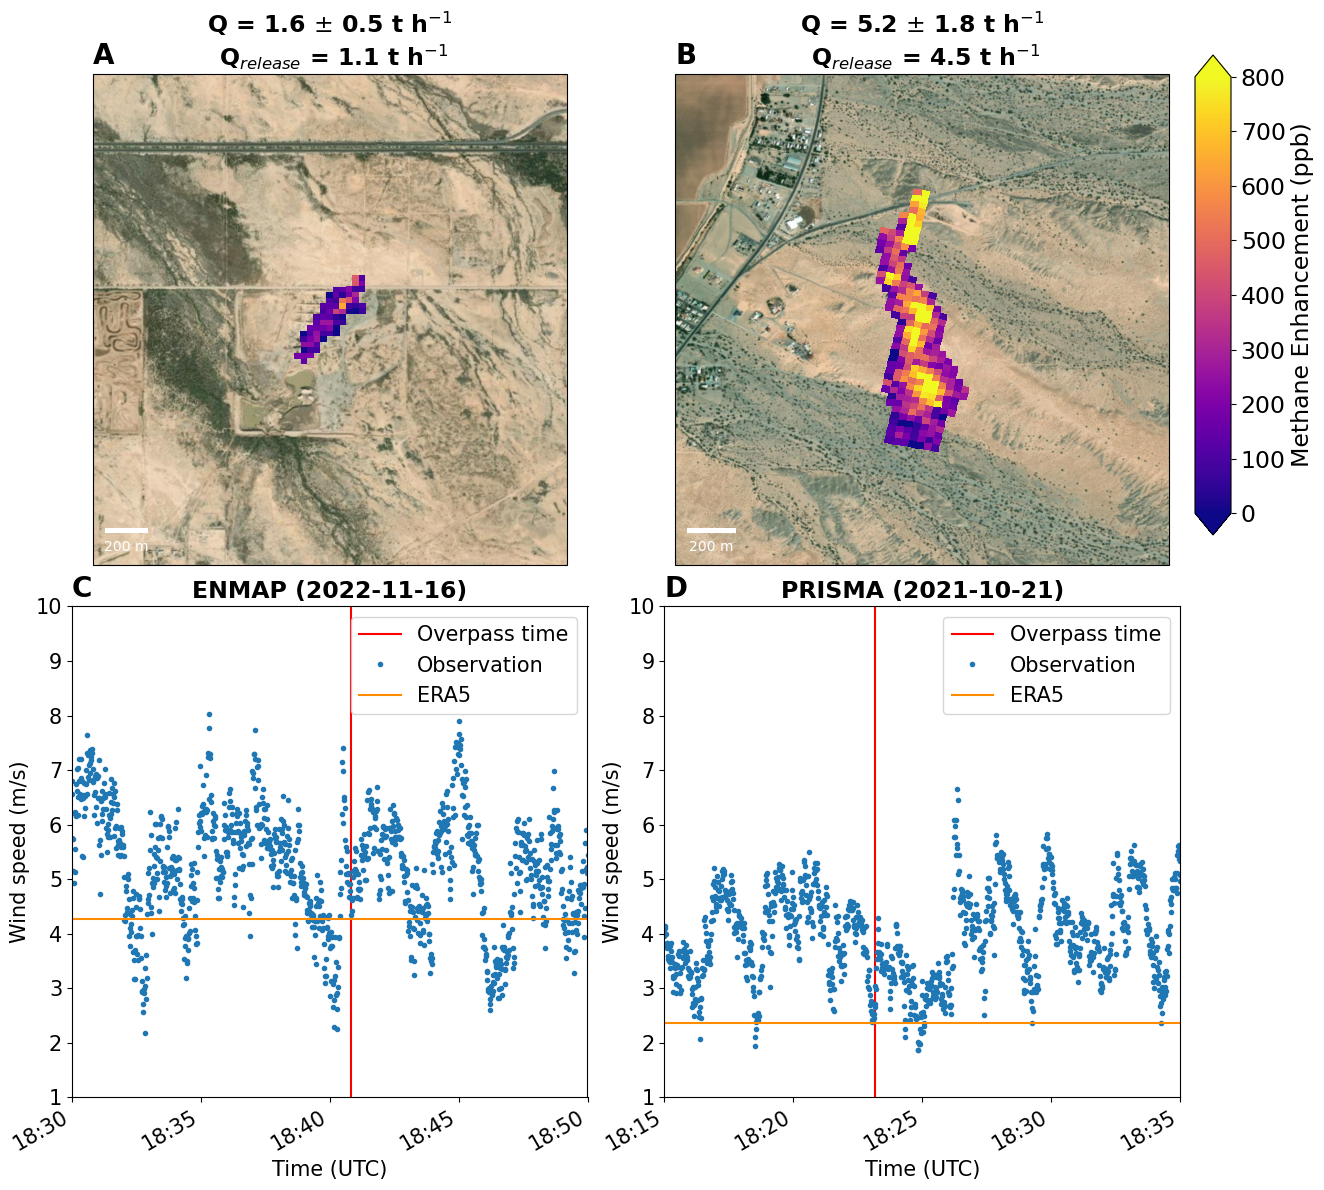

In [13]:
utm_zone = CRS.from_epsg(da_1.rio.crs.to_epsg()).to_dict()['zone']
crs = ccrs.UTM(zone=utm_zone, southern_hemisphere=True)

# fig, axs = plt.subplots(figsize=(10, 5), ncols=2,
#                       #  facecolor = plt.cm.Blues(.3),
#                        subplot_kw={'projection':ccrs.PlateCarree()},
#                      #   constrained_layout=True,
#                        )

# ax = axs[0]

fig = plt.figure(figsize=(12, 12))
ax_list = []

ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())
ax_list.append(ax)

m = da_1.plot(x='longitude', y='latitude',
            ax=ax, vmin=0, vmax=800, cmap='plasma',
            add_colorbar=False, rasterized=True
           )

lon_min = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].min() - 0.01
lon_max = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].max() + 0.01
lat_min = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].min() - 0.01
lat_max = da_1.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].max() + 0.01

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
cx.add_basemap(ax, crs=ccrs.PlateCarree(), source=cx.providers.Esri.WorldImagery)
# remove watermark
ax.texts[0].remove()

points = gpd.GeoSeries(
    [Point(lon_min, lat_min), Point(lon_min-1, lat_min)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(crs)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

scalebar = ScaleBar(distance_meters, location='lower left', pad=0.05, border_pad=0.5, frameon=False, color='white')
ax.add_artist(scalebar)

emission_str = f"{(df_1['emission']/1e3).round(1).item()} $\pm$ {(df_1['emission_uncertainty']/1e3).round(1).item()} t h$^{{-1}}$"
# ax.set_title(da_1.attrs['start_time'][:10] + '\n' + 'Q: '+ emission_str + ' Q$_{{release}}$: 1.1 t h$^{{-1}}$')
ax.set_title('Q = '+ emission_str + '\n Q$_{{release}}$ = 1.1 t h$^{{-1}}$')

# ax = axs[1]
ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())
ax_list.append(ax)

m = da_2.plot(x='longitude', y='latitude',
            ax=ax, vmin=0, vmax=800, cmap='plasma',
            add_colorbar=False, rasterized=True
           )

lon_min = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].min() - 0.007
lon_max = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['longitude'].max() + 0.007
lat_min = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].min() - 0.005
lat_max = da_2.dropna(dim='y', how='all').dropna(dim='x', how='all')['latitude'].max() + 0.005

ax.set_extent([lon_min, lon_max, lat_min, lat_max])
cx.add_basemap(ax, crs=ccrs.PlateCarree(), source=cx.providers.Esri.WorldImagery)
# remove watermark
ax.texts[0].remove()

# add colorbar
# cax = fig.add_axes([1, 0.05, 0.03, 0.8])
cax = fig.add_axes([1, 0.55, 0.03, 0.4])
cb = fig.colorbar(m, cax=cax, extend='both', orientation="vertical")
cb.ax.tick_params(labelsize=17)
cb.ax.set_ylabel('Methane Enhancement (ppb)', fontsize=17)

points = gpd.GeoSeries(
    [Point(lon_min, lat_min), Point(lon_min-1, lat_min)], crs=4326
)  # Geographic WGS 84 - degrees
points = points.to_crs(crs)  # Projected WGS 84 - meters
distance_meters = points[0].distance(points[1])

scalebar = ScaleBar(distance_meters, location='lower left', pad=0.05, border_pad=0.5, frameon=False, color='white')
ax.add_artist(scalebar)

emission_str = f"{(df_2['emission']/1e3).round(1).item()} $\pm$ {(df_2['emission_uncertainty']/1e3).round(1).item()} t h$^{{-1}}$"
ax.set_title('Q = '+ emission_str + '\n Q$_{{release}}$ = 4.5 t h$^{{-1}}$')

fig.tight_layout()

for n, ax in enumerate(axs):
    # plot wind quivers
    ax.text(0, 1.02, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')


axs[0].scatter(-111.7857730, 32.8218205, marker='x', c='w', s=60, linewidth=3)
axs[1].scatter(-114.489150, 33.630645, marker='x', c='w', s=60, linewidth=3)

ax = fig.add_subplot(2, 2, 3)
ax_list.append(ax)
plot_wspd(df_wind, da_1, ax)
ax.axhline(df_1['wind_speed'].item(), c='darkorange', label='ERA5')
plt.legend()

ax = fig.add_subplot(2, 2, 4)
ax_list.append(ax)
plot_wspd(df_wind, da_2, ax)
ax.axhline(df_2['wind_speed'].item(), c='darkorange', label='ERA5')
plt.legend()


fig.tight_layout()

for n, ax in enumerate(ax_list):
    # plot wind quivers
    ax.text(0, 1.02, string.ascii_uppercase[n],
            transform=ax.transAxes, 
            size=20, weight='bold')
    
fig.savefig('../figures/control_release.pdf', bbox_inches='tight')